In [ ]:
# Swapping Auto Encoder using PyTorch
# Semantic Segmentation on MIT ADE20K dataset in PyTorch

In [ ]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

Process is interrupted.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil, os
shutil.copy("/content/drive/MyDrive/segmenter/resnet50/decoder_epoch_20.pth", "/content/ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth")
shutil.copy("/content/drive/MyDrive/segmenter/resnet50/encoder_epoch_20.pth", "/content/ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth")

'/content/ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth'

In [ ]:
import scipy.io
import cv2

mat = scipy.io.loadmat('data/color150.mat')

print(mat['colors'][1])
for i in range(len(mat['colors'])):
    mat['colors'][i] = [0, 0, 0]
mat['colors'][1] = [255, 255, 255] #originally it is 180 120 120
print(mat['colors'][1])
scipy.io.savemat('data/color150_white.mat',mat)

for i in range(len(mat['colors'])):
    mat['colors'][i] = [255, 255, 255]
mat['colors'][1] = [0, 0, 0] #originally it is 180 120 120
print(mat['colors'][1])
scipy.io.savemat('data/color150_black.mat',mat)

[180 120 120]
[255 255 255]
[0 0 0]


In [ ]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150_white.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    #display(PIL.Image.fromarray(im_vis))
    return PIL.Image.fromarray(im_vis)

In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='/content/ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='/content/ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [ ]:
#!pip3 install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio===0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install dominate torchgeometry func-timeout tqdm matplotlib opencv_python lmdb numpy GPUtil Pillow scikit-learn visdom ninja

     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 44 kB 2.5 MB/s 
     |████████████████████████████████| 676 kB 10.9 MB/s 
     |████████████████████████████████| 108 kB 48.6 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15095 sha256=06b41bb2396644dd1c21b9f00f54371b80693147e42628006ae1c8d5f9579596
  Stored in directory: /root/.cache/pip/wheels/68/b5/a5/67c4364c354e141f5a1bd3ec568126f77877ab7554cf5af8cb
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=23432b4ec71b51b92db3db24b5bbab39f35b9d45d19abae1c7296a6d2c6fc638
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=62903157b7c6b259a931ac5c0218c8eda657b34e28b6c28b6dab097ae7145198
  Stored in directory: /root/.cache/pi

In [ ]:
!git clone https://github.com/taesungp/swapping-autoencoder-pytorch/

Cloning into 'swapping-autoencoder-pytorch'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 179 (delta 79), reused 124 (delta 44), pack-reused 0
Receiving objects: 100% (179/179), 3.99 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [ ]:
cd swapping-autoencoder-pytorch/

/content/swapping-autoencoder-pytorch


In [ ]:
!mkdir /content/swapping-autoencoder-pytorch/checkpoints
!mkdir /content/swapping-autoencoder-pytorch/checkpoints/church_pretrained
!mkdir /content/swapping-autoencoder-pytorch/checkpoints/church_default

In [ ]:
import shutil, os
shutil.copy("/content/drive/MyDrive/church_pretrained/latest_checkpoint.pth", "/content/swapping-autoencoder-pytorch/checkpoints/church_pretrained/latest_checkpoint.pth")
shutil.copy("/content/drive/MyDrive/church_default/latest_checkpoint.pth", "/content/swapping-autoencoder-pytorch/checkpoints/church_default/latest_checkpoint.pth")

'/content/swapping-autoencoder-pytorch/checkpoints/church_default/latest_checkpoint.pth'

In [ ]:
def visualize_result(img, pred, index=None):
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    return im_vis
    return PIL.Image.fromarray(im_vis)
    #display(PIL.Image.fromarray(im_vis))

In [ ]:
def return_building_images_from_localfile(img):
  # Load and normalize one image as a singleton tensor batch
  pil_to_tensor = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
          std=[0.229, 0.224, 0.225])  # across a large photo dataset.
  ])
  pil_image = PIL.Image.open(img).convert('RGB')
  img_original = numpy.array(pil_image)
  img_data = pil_to_tensor(pil_image)
  singleton_batch = {'img_data': img_data[None].cuda()}
  output_size = img_data.shape[1:]
  # Run the segmentation at the highest resolution.
  with torch.no_grad():
      scores = segmentation_module(singleton_batch, segSize=output_size)      
  # Get the predicted scores for each pixel
  _, pred = torch.max(scores, dim=1)
  pred = pred.cpu()[0].numpy()
  return visualize_result(img_original, pred)

In [ ]:
from google.colab import files
uploaded_1 = files.upload()

MessageError: ignored

In [ ]:
uploaded_2 = files.upload()

Saving style.jpg to style.jpg
time: 5.73 s (started: 2021-12-29 19:24:23 +00:00)


In [ ]:
!mkdir images

In [ ]:
from pathlib import Path
Path(list(uploaded_1.keys())[0]).rename("images/"+list(uploaded_1.keys())[0])
os.rename("images/"+list(uploaded_1.keys())[0], "images/content.jpg")
Path(list(uploaded_2.keys())[0]).rename("images/"+list(uploaded_2.keys())[0])
os.rename("images/"+list(uploaded_2.keys())[0], "images/style.jpg")

time: 4.87 ms (started: 2021-12-29 19:24:46 +00:00)


In [ ]:
!python test.py --evaluation_metrics simple_swapping \
--preprocess scale_shortside --load_size 256 \
--crop_size 256 \
--name church_pretrained  \
--input_structure_image /content/swapping-autoencoder-pytorch/images/content.jpg \
--input_texture_image /content/swapping-autoencoder-pytorch/images/style.jpg \

Using /root/.cache/torch_extensions/py37_cu111 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py37_cu111/fused/build.ninja...
Building extension module fused...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module fused...
Loading custom kernel...
Using /root/.cache/torch_extensions/py37_cu111 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py37_cu111/upfirdn2d/build.ninja...
Building extension module upfirdn2d...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module upfirdn2d...
parsing args...
----------------- Options ---------------
            R1_once_every: 16                            
               batch_size: 1   

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow

mask = return_building_images_from_localfile('/content/swapping-autoencoder-pytorch/images/content.jpg')
#cv2_imshow(mask[0:256,256:512])
mask = mask[0:256,256:512]
#mask = cv2.imread('/content/swapping-autoencoder-pytorch/images/mask.jpg')
mask_not = cv2.bitwise_not(mask)
orig_img = cv2.imread('/content/swapping-autoencoder-pytorch/images/content.jpg')
orig_img = cv2.bitwise_and(orig_img, mask_not)
#cv2_imshow(orig_img)
h_zero = cv2.imread('/content/swapping-autoencoder-pytorch/results/church_pretrained/simpleswapping/'+os.listdir('/content/swapping-autoencoder-pytorch/results/church_pretrained/simpleswapping')[0]) 
h_mask_and_merge = cv2.bitwise_and(h_zero, mask)
#cv2_imshow(h_mask_and_merge)
h_bar = cv2.bitwise_xor(orig_img, h_mask_and_merge)
#cv2_imshow(h_bar)
cv2.imwrite("/content/swapping-autoencoder-pytorch/results/church_pretrained/simpleswapping/h_bar.png", h_bar)

True

In [ ]:
my_var = os.listdir('/content/swapping-autoencoder-pytorch/results/church_pretrained/simpleswapping')[0]
{my_var}

{'h_bar.png'}

In [ ]:
!python test.py --evaluation_metrics simple_swapping \
--preprocess scale_shortside --load_size 256 \
--crop_size 256 \
--name church_default  \
--input_structure_image /content/swapping-autoencoder-pytorch/images/content.jpg \
--input_texture_image /content/swapping-autoencoder-pytorch/results/church_pretrained/simpleswapping/h_bar.png \

Using /root/.cache/torch_extensions/py37_cu111 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py37_cu111/fused/build.ninja...
Building extension module fused...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module fused...
Loading custom kernel...
Using /root/.cache/torch_extensions/py37_cu111 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py37_cu111/upfirdn2d/build.ninja...
Building extension module upfirdn2d...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module upfirdn2d...
parsing args...
----------------- Options ---------------
            R1_once_every: 16                            
               batch_size: 1   

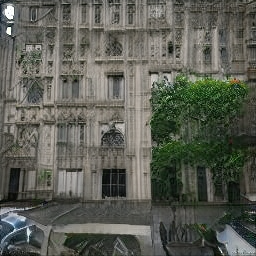

In [ ]:
img = cv2.imread('/content/swapping-autoencoder-pytorch/results/church_default/simpleswapping/'+os.listdir('/content/swapping-autoencoder-pytorch/results/church_default/simpleswapping')[0])
cv2_imshow(img)

In [ ]:
!rm -rf /content/swapping-autoencoder-pytorch/images
!mkdir /content/swapping-autoencoder-pytorch/images
!rm -rf /content/swapping-autoencoder-pytorch/results/church_default/simpleswapping
!mkdir /content/swapping-autoencoder-pytorch/results/church_default/simpleswapping
!rm -rf /content/swapping-autoencoder-pytorch/results/church_pretrained/simpleswapping
!mkdir /content/swapping-autoencoder-pytorch/results/church_pretrained/simpleswapping

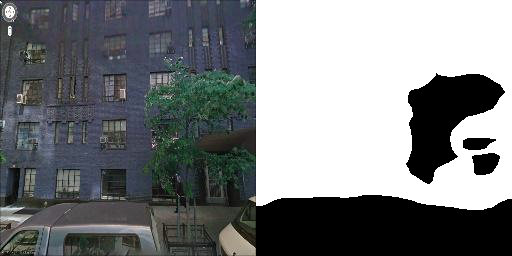

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow

mask = return_building_images_from_localfile('/content/swapping-autoencoder-pytorch/images/content.jpg')
cv2_imshow(mask)

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 140 µs (started: 2021-12-29 19:23:48 +00:00)


In [ ]:
mask = return_building_images_from_localfile('/content/swapping-autoencoder-pytorch/images/content.jpg')
  